<a href="https://colab.research.google.com/github/MHHamdan/LLM_Reasoning/blob/main/Anomaly_detection_with_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Anomaly detection with embeddings

<table align="left">
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Anomaly_detection_with_embeddings.ipynb"><img src="https://github.com/google-gemini/cookbook/blob/main/images/colab_logo_32px.png?raw=1" />Run in Google Colab</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to use the embeddings from the Gemini API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and detect outliers outside a particular radius of the central point of each categorical cluster.


In [ ]:
!pip install -U -q "google-generativeai>=0.7.2"

In [ ]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import google.generativeai as genai

# Used to securely store your API key
from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [ ]:
API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=API_KEY)

## Prepare dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [ ]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [ ]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data]

In [ ]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [ ]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

<ipython-input-8-c979cf6a7a32>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


,index,Text,Label,Class Name
0,1650,"Re: Once tapped, your code is no good any mor...",11,sci.crypt
1,1651,"Re: Once tapped, your code is no good any mor...",11,sci.crypt
2,1652,Re: Re-inventing Crypto Policy? An EFF State...,11,sci.crypt
3,1653,"Re: Would ""clipper"" make a good cover for oth...",11,sci.crypt
4,1654,Re: Trinomial-Based PRNG\nOrganization: Schoo...,11,sci.crypt
...,...,...,...,...
595,2245,Lindbergh and the moon \nOrganization: Univer...,14,sci.space
596,2246,Cold gas roll control thruster tanks\nOrganiza...,14,sci.space
597,2247,Re: PLANETS STILL: IMAGES ORBIT BY ETHER TWIS...,14,sci.space
598,2248,Re: Why DC-1 will be the way of the future.\n...,14,sci.space


In [ ]:
df_train['Class Name'].value_counts()

,count
Class Name,
sci.crypt,150
sci.electronics,150
sci.med,150
sci.space,150


## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the new embeddings model, embedding-001, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")['embedding']
    return np.array(embedding)

  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)
df_train.drop('index', axis=1, inplace=True)

  0%|          | 0/600 [00:00<?, ?it/s]

## Dimensionality reduction

The dimension of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [ ]:
len(df_train['Embeddings'][0])

768

In [ ]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [ ]:
tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

In [ ]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-40.969662,2.635904,sci.crypt
1,-28.299372,-2.422620,sci.crypt
2,-35.511490,-7.513160,sci.crypt
3,-48.113018,4.225831,sci.crypt
4,-25.259232,-14.521727,sci.crypt
...,...,...,...
595,5.322392,29.096216,sci.space
596,15.293025,9.806635,sci.space
597,10.153075,8.876897,sci.space
598,3.044561,-12.592345,sci.space


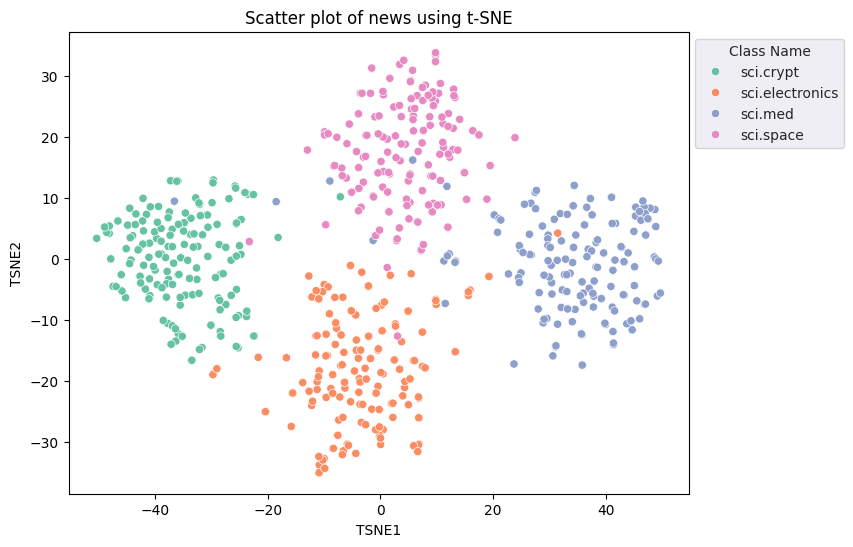

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [ ]:
def get_centroids(df_tsne):
  # Get the centroid of each cluster
  centroids = df_tsne.groupby('Class Name').mean()
  return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,-35.262508,-0.025903
sci.electronics,-3.281268,-17.625010
sci.med,33.475155,-0.624597
sci.space,4.499481,17.525898


In [ ]:
def get_embedding_centroids(df):
  emb_centroids = dict()
  grouped = df.groupby('Class Name')
  for c in grouped.groups:
    sub_df = grouped.get_group(c)
    # Get the centroid value of dimension 768
    emb_centroids[c] = np.mean(sub_df['Embeddings'], axis=0)

  return emb_centroids

In [ ]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

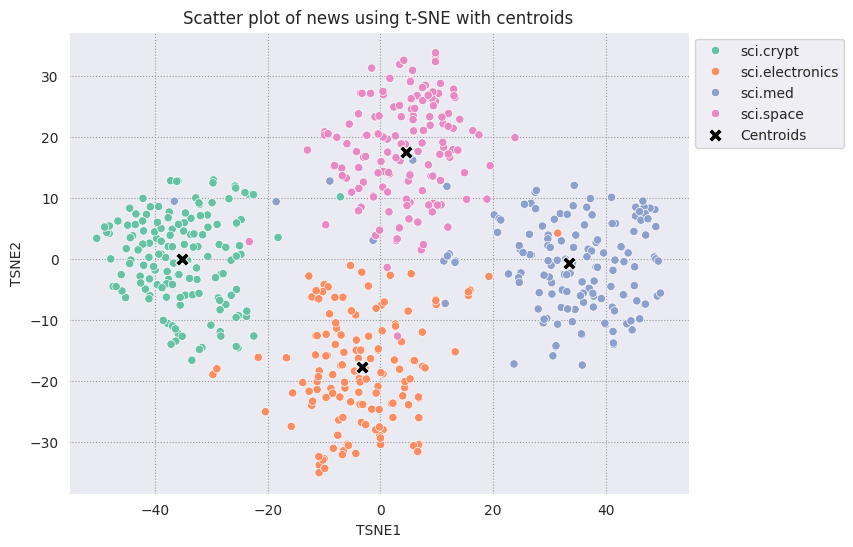

In [ ]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [ ]:
def calculate_euclidean_distance(p1, p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
  for idx, row in df.iterrows():
    class_name = row['Class Name'] # Get class name of row
    # Compare centroid distances
    dist = calculate_euclidean_distance(row['Embeddings'],
                                        emb_centroids[class_name])
    df.at[idx, 'Outlier'] = dist > radius

  return len(df[df['Outlier'] == True])

In [ ]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_train, emb_c, i))

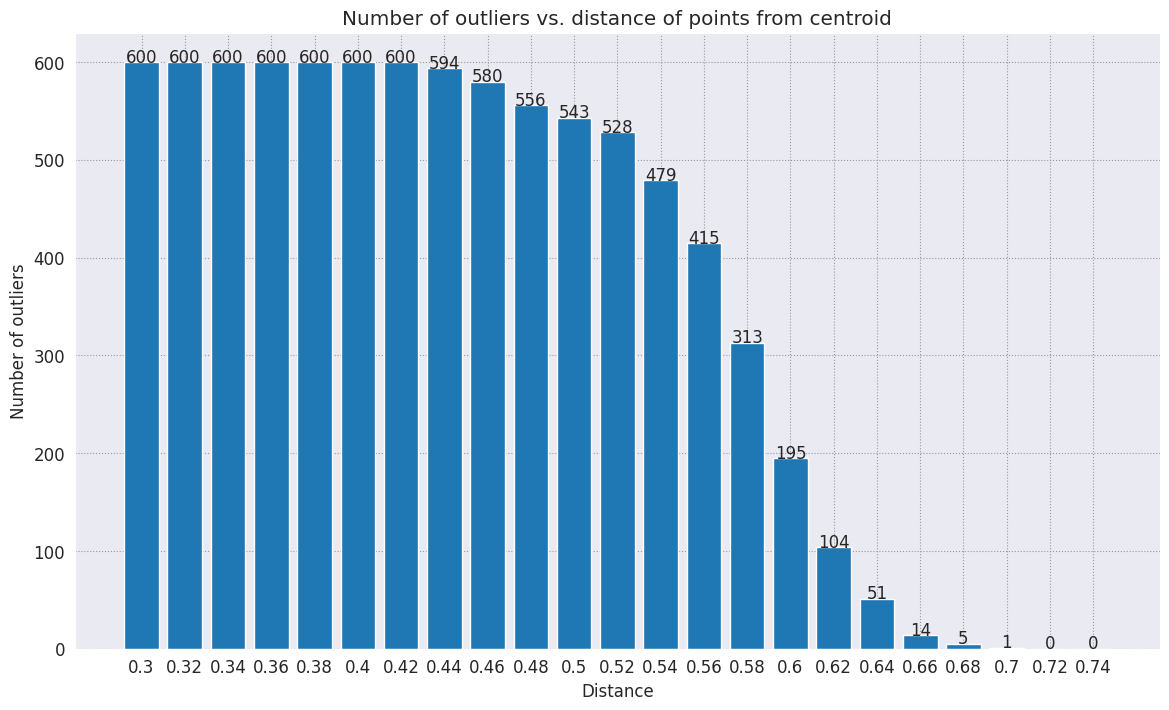

In [ ]:
# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
  plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.62 is used, but you can change this value.

In [ ]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train['Outlier'] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
4,Re: Trinomial-Based PRNG\nOrganization: Schoo...,11,sci.crypt,"[-0.008872376, -0.060836125, -0.061392497, -0....",True
6,Re: What is going on?...\nLines: 17\nOrganiza...,11,sci.crypt,"[-0.0046481607, -0.034073144, -0.045407247, -0...",True
12,Re: The source of that announcement\nOrganiza...,11,sci.crypt,"[0.0148236565, -0.02399558, -0.05186253, -0.07...",True
36,Re: Source of random bits on a Unix workstati...,11,sci.crypt,"[0.024040423, -0.067498654, -0.097997, -0.0439...",True
38,Re: PEM and MIME\nOrganization: Personal Usen...,11,sci.crypt,"[0.010670432, -0.010967547, -0.05260994, -0.02...",True


In [ ]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]

Plot the outliers and denote them using a transparent red color.

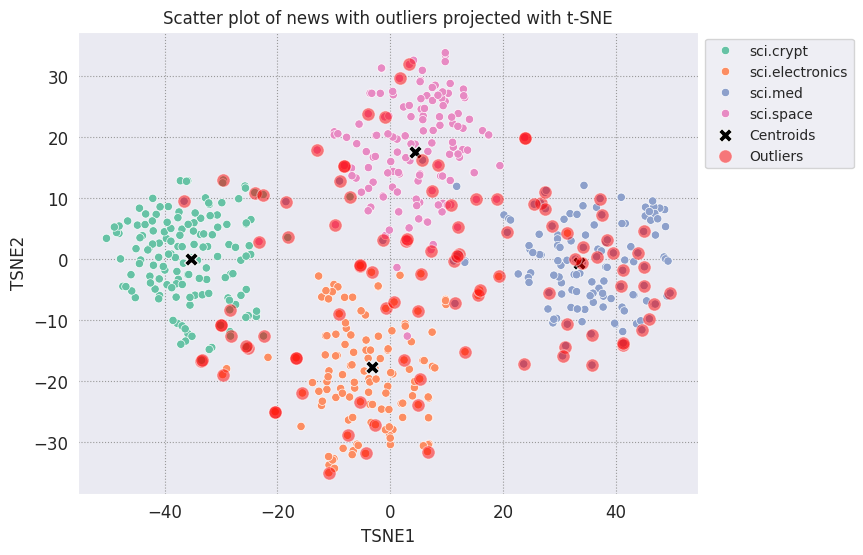

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [ ]:
sci_crypt_outliers = df_outliers[df_outliers['Class Name'] == 'sci.crypt']
print(sci_crypt_outliers['Text'].iloc[0])

 Re: Trinomial-Based PRNG
Organization: School of Mathematical Sciences, University of Bath, UK
Lines: 27

I tried to mail Peter Boucher, who posted the question, but my e-mail
bounced, so, apologies to thsoe who are not interested.
>trinomials are all of the form X**a + X**b + 1, where a
Have you read:
Bremner,A.,
On Trinomials of Type x$+n$-+Ax$+m$-+1.
Math. Scand. 49 pp. 145-155.
Zbl. 458.12012.
MR 83k:12002.

Ljunggren,W.,
On the Irreducibility of Certain Trinomials and Quadrinomials.
Math. Scand. 8 pp. 65-70.
.

Tverberg,H.,
On the Irreducibility of the Trinomials
x$+n$-$mpm$$x$+m$-$mpm$$1.
Math. Scand. 8 pp. 121-126.

Tverberg,H.,
On Cubic Factors of Certain Trinomials.
Math. Scand. 53 pp. 178-184.
Zbl. 513.12003.

James Davenport




In [ ]:
sci_elec_outliers = df_outliers[df_outliers['Class Name'] == 'sci.electronics']
print(sci_elec_outliers['Text'].iloc[0])

pwm control thru software
Lines: 17
Nntp-Posting-Host: v9001.ntu.ac.sg
Organization: Nanyang Technological University - Singapore


currently I am using the 8051 microcontroller with external eprom..

In order to drive the dc motor  I use the Pulse width modultion 

thru software control. However I am afraid that

they will be overheads and thus alter the pulse timing. My question is 

is the software pwm control reliable?. I understand that port 0 is a latch

and so I vary the duty cycle by setting it high first and at the desire 

duty cycle then I set low..? Any improments ?
 

 



In [ ]:
sci_med_outliers = df_outliers[df_outliers['Class Name'] == 'sci.med']
print(sci_med_outliers['Text'].iloc[0])

 Re: jiggers
Distribution: world
X-NewsSoftware: GRn 1.16f  by Mike Schwartz & Michael B. Smith
Organization: Privately owned and operated UUCP site.
Lines: 26

In article <1ppae1$>   writes:
> a friend of mine has a very severe cause of jiggers -
> for over a year now - they cause him a lot of pain.
>
> i recently read  about a possible
> cure for jiggers.  does anyone have any information on
> this?  i can't remember the name of the treatment, or
> where i read it.
>

I'll probably get flamed for this, but when I was a kid we would go to
my uncles cabin on Middle Bass Island on Lake Erie. We always came home
with a nasty case of jiggers . My mother would paint the bumps with clear
finger nail polish. This was repeated daily for about a week or so. The
application of the polish is supposed to suffocate them as it seals of
the skin. All I can say is it worked for us. One word of caution
though. Putting finger nail polish on a jigger bite stings like hell.



--
________________________

In [ ]:
sci_space_outliers = df_outliers[df_outliers['Class Name'] == 'sci.space']
print(sci_space_outliers['Text'].iloc[0])

 HST Servicing Mission Scheduled for 11 Days
Organization: Jet Propulsion Laboratory
Lines: 88
Distribution: world
NNTP-Posting-Host: kelvin.jpl.nasa.gov
Keywords: HST
News-Software: VAX/VMS VNEWS 1.41    

Ed Campion
Headquarters, Washington, D.C.                             April 23, 1993


Kyle Herring
Johnson Space Center, Houston


RELEASE:  93-76

HUBBLE TELESCOPE SERVICING MISSION SCHEDULED FOR ELEVEN DAYS

	The December flight of Endeavour on Space Shuttle mission STS-61 to
service the Hubble Space Telescope  has been scheduled as an 11 day
mission designed to accommodate a record five spacewalks with the capability
for an additional two, if needed.

	The decision to schedule five extravehicular activities, or EVAs, was
reached following extensive evaluations of underwater training, maneuver times
required using the Shuttle's robot arm based on software simulations and actual
EVA tasks on previous missions.

	"Basically what we've done by going to five EVAs rather than three is

## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that t-SNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).